Begun 7/16/2024

The goal of this notebook is to test for the correct window factor by which to adjust the number of modes in each bin. The Das et al (2008) paper appendix gives w2^2/w4, but I am currently using just w2. 

To do this, I will simulate 100 (or 1000) sets of alms in healpix from the input CAMB spectrum, then use pixell's alm2map function to convert these into map based simulations in pixell. I will then use the real mask and code from a depth-1 map to calculate power spectra. We can compare the variance of these spectra to the theoretical value in equation A8 of the Das appendix. If the measured cosmic variance matches the analytical covariance for different sized masks, then w2 is the right factor.

Update from 8/20/24

After testing parts of the code and then testing a bin size of 1, the bottom has the more realistic and interesting results for a bin size of 50. The measured variance is further away from the theoretical variance than expected, but the measured number of Fourier pixels in each bin (the "bincount" variable) matches what is expected. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap, enplot, reproject, utils, curvedsky
from tqdm import tqdm
import nawrapper as nw
import yaml
import time
import healpy as hp

In [2]:
# Loading in CAMB input spectra
ell_camb,DlTT_camb,DlEE_camb,DlBB_camb,DlTE_camb = np.loadtxt( \
            "/home/zbh5/act_analysis/act_axion_analysis/resources/camb_19413797_lensedtotcls.dat", \
                                                              usecols=(0,1,2,3,4), unpack=True) 
# Note that ell_camb runs from 2 to 5400
# Healpy expects ell to start at zero
# Initializing new arrays with first two entries set to zero
arr_len = ell_camb.size+2
ell = np.zeros(arr_len)
ell[1] = 1
ell[2:] = ell_camb
ClTT = np.zeros(arr_len)
ClEE = np.zeros(arr_len)
ClTE = np.zeros(arr_len)
ClBB = np.zeros(arr_len)
# convert Dl to Cl
ClTT[2:] = DlTT_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClEE[2:] = DlEE_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClTE[2:] = DlTE_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClBB[2:] = DlBB_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))

In [3]:
# Generating alms from input C_ells
#alm = hp.sphtfunc.synalm((ClTT,ClTE,ClEE,ClBB))
alm = hp.sphtfunc.synalm(ClTT) # Just starting with TT alone for simplicity

# Seems another option would be to use pixell's version of this
# https://pixell.readthedocs.io/en/latest/reference.html#pixell.curvedsky.rand_alm

In [4]:
print(alm.shape)
print(type(alm))
print(type(alm[0]))

(14588101,)
<class 'numpy.ndarray'>
<class 'numpy.complex128'>


In [5]:
# Functions for calculating power spectra from depth-1 and reference map to use as noise in sims
def make_tapered_mask(map_to_mask,filter_radius=1.0,plot=False):
    """
        Makes a mask for a given map based on where the ivar map is nonzero.
        Also apodizes the mask and gets the indices of where the apodized
        mask is not equal to one (everything tapered or outside the mask)
        in order to set all points but those to zero after filtering.
    """
    footprint = 1*map_to_mask.astype(bool)
    mask = nw.apod_C2(footprint,filter_radius)
    
    # Getting points to set to zero after filtering
    indices = np.nonzero(mask != 1)
    
    if plot:
        eshow(mask, **keys_eshow)
    
    return mask, indices

def load_and_filter_depth1_with_T(depth1_path, plot=False):
    print(depth1_path)
    depth1_maps = enmap.read_map(depth1_path)
    ivar_path = depth1_path[:-8] + "ivar.fits"
    depth1_ivar = 0.5*enmap.read_map(ivar_path) # 0.5 for polarization noise
        
    # Apodize and filter depth-1
    depth1_mask, depth1_indices = make_tapered_mask(depth1_ivar,filter_radius=1.0,plot=plot)
    depth1_TEB = enmap.map2harm(depth1_maps*depth1_mask, normalize = "phys")
    
    w2 = np.mean(depth1_mask**2)
        
    # Not sure if I need this, but it is the default behavior in kfilter_map in nawrapper
    if unpixwin:  # remove pixel window in Fourier space
        for i in range(len(depth1_maps)):
            wy, wx = enmap.calc_window(depth1_maps[i].shape)
            depth1_TEB[i] /= wy[:, np.newaxis]
            depth1_TEB[i] /= wx[np.newaxis, :]
        
    ly, lx = depth1_TEB.lmap()
    kfilter_x = np.abs(lx) >= kx_cut
    kfilter_y = np.abs(ly) >= ky_cut
    filtered_TEB = depth1_TEB * kfilter_x * kfilter_y
    
    return filtered_TEB[0], filtered_TEB[1], filtered_TEB[2], w2, depth1_mask

def spectrum_from_maps(map1, map2, b_ell_bin_1, b_ell_bin_2, w2, bins):
    """Function modified from the one in ACT DR4/5 NB7 for binning a power spectrum for two maps.
       This function does account for a window correction for the apodizing at this point.
       Also accounts for a beam correction using a beam defined by b_ell.
    """
    spectrum = np.real(map1*np.conj(map2))

    # Dividing by an approx. correction for the loss of power from tapering
    spectrum /= w2

    modlmap = map1.modlmap()

    # Bin the power spectrum
    digitized = np.digitize(np.ndarray.flatten(modlmap), bins, right=True)
    bincount = np.bincount(digitized)[1:-1]
    binned = np.bincount(digitized, spectrum.reshape(-1))[1:-1]/bincount

    binned /= (b_ell_bin_1*b_ell_bin_2)

    return binned, bincount

In [6]:
# Generating test pixell map in same shape as a depth-1 map
obs_list = "/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/dr6_depth1_test_map_list.txt"
with open(obs_list) as f:
    lines = f.read().splitlines()

# No filtering or pixel window since I'm just using the shape for the sims
unpixwin=False
kx_cut=0
ky_cut=0
    
depth1_path = '/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/' + lines[0]
depth1_T, depth1_E, depth1_B, w2, depth1_mask = load_and_filter_depth1_with_T(depth1_path)

test_map = curvedsky.alm2map(alm, depth1_T.real, spin=[0]) 

/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/depth1_1494463440_pa4_f150_map.fits


In [7]:
# Trying this with pixell.curvedsky.rand_alm
alm_pix = curvedsky.rand_alm(ClTT)

In [8]:
print(type(alm_pix))
print(alm_pix.shape)
print(type(alm_pix[0]))

<class 'numpy.ndarray'>
(14588101,)
<class 'numpy.complex128'>


In [9]:
test_map_pix = curvedsky.alm2map(alm_pix, depth1_T.real, spin=[0]) 

In [10]:
print(depth1_T.shape)
print(type(depth1_T))
print(type(depth1_T[0][0]))
print(type(depth1_T.real[0][0]))

(3408, 7178)
<class 'pixell.enmap.ndmap'>
<class 'numpy.complex128'>
<class 'numpy.float64'>


In [11]:
keys_eshow = {"downgrade": 2, "ticks": 5, "colorbar": True, "font_size": 40}

def eshow(x,**kwargs): 
    ''' Function to plot the maps for debugging '''
    plots = enplot.get_plots(x, **kwargs)
    enplot.show(plots, method = "auto")

In [12]:
#eshow(test_map, **keys_eshow)

In [13]:
#eshow(test_map_pix, **keys_eshow)

In [14]:
#eshow(depth1_T, **keys_eshow)

In [15]:
depth1_T = enmap.read_map(depth1_path)[0]

In [16]:
#eshow(depth1_T, **keys_eshow)

In [17]:
print(type(depth1_T[0][0]))

<class 'numpy.float32'>


In [18]:
test_map = curvedsky.alm2map(alm, depth1_T, spin=[0]) 

In [19]:
test_map_pix = curvedsky.alm2map(alm_pix, depth1_T, spin=[0]) 

In [112]:
#eshow(test_map, **keys_eshow)

In [21]:
#eshow(test_map_pix, **keys_eshow)

In [22]:
alm2 = hp.sphtfunc.synalm(ClTT)
test_map2 = curvedsky.alm2map(alm2, depth1_T, spin=[0]) 

In [23]:
#eshow(test_map2, **keys_eshow)

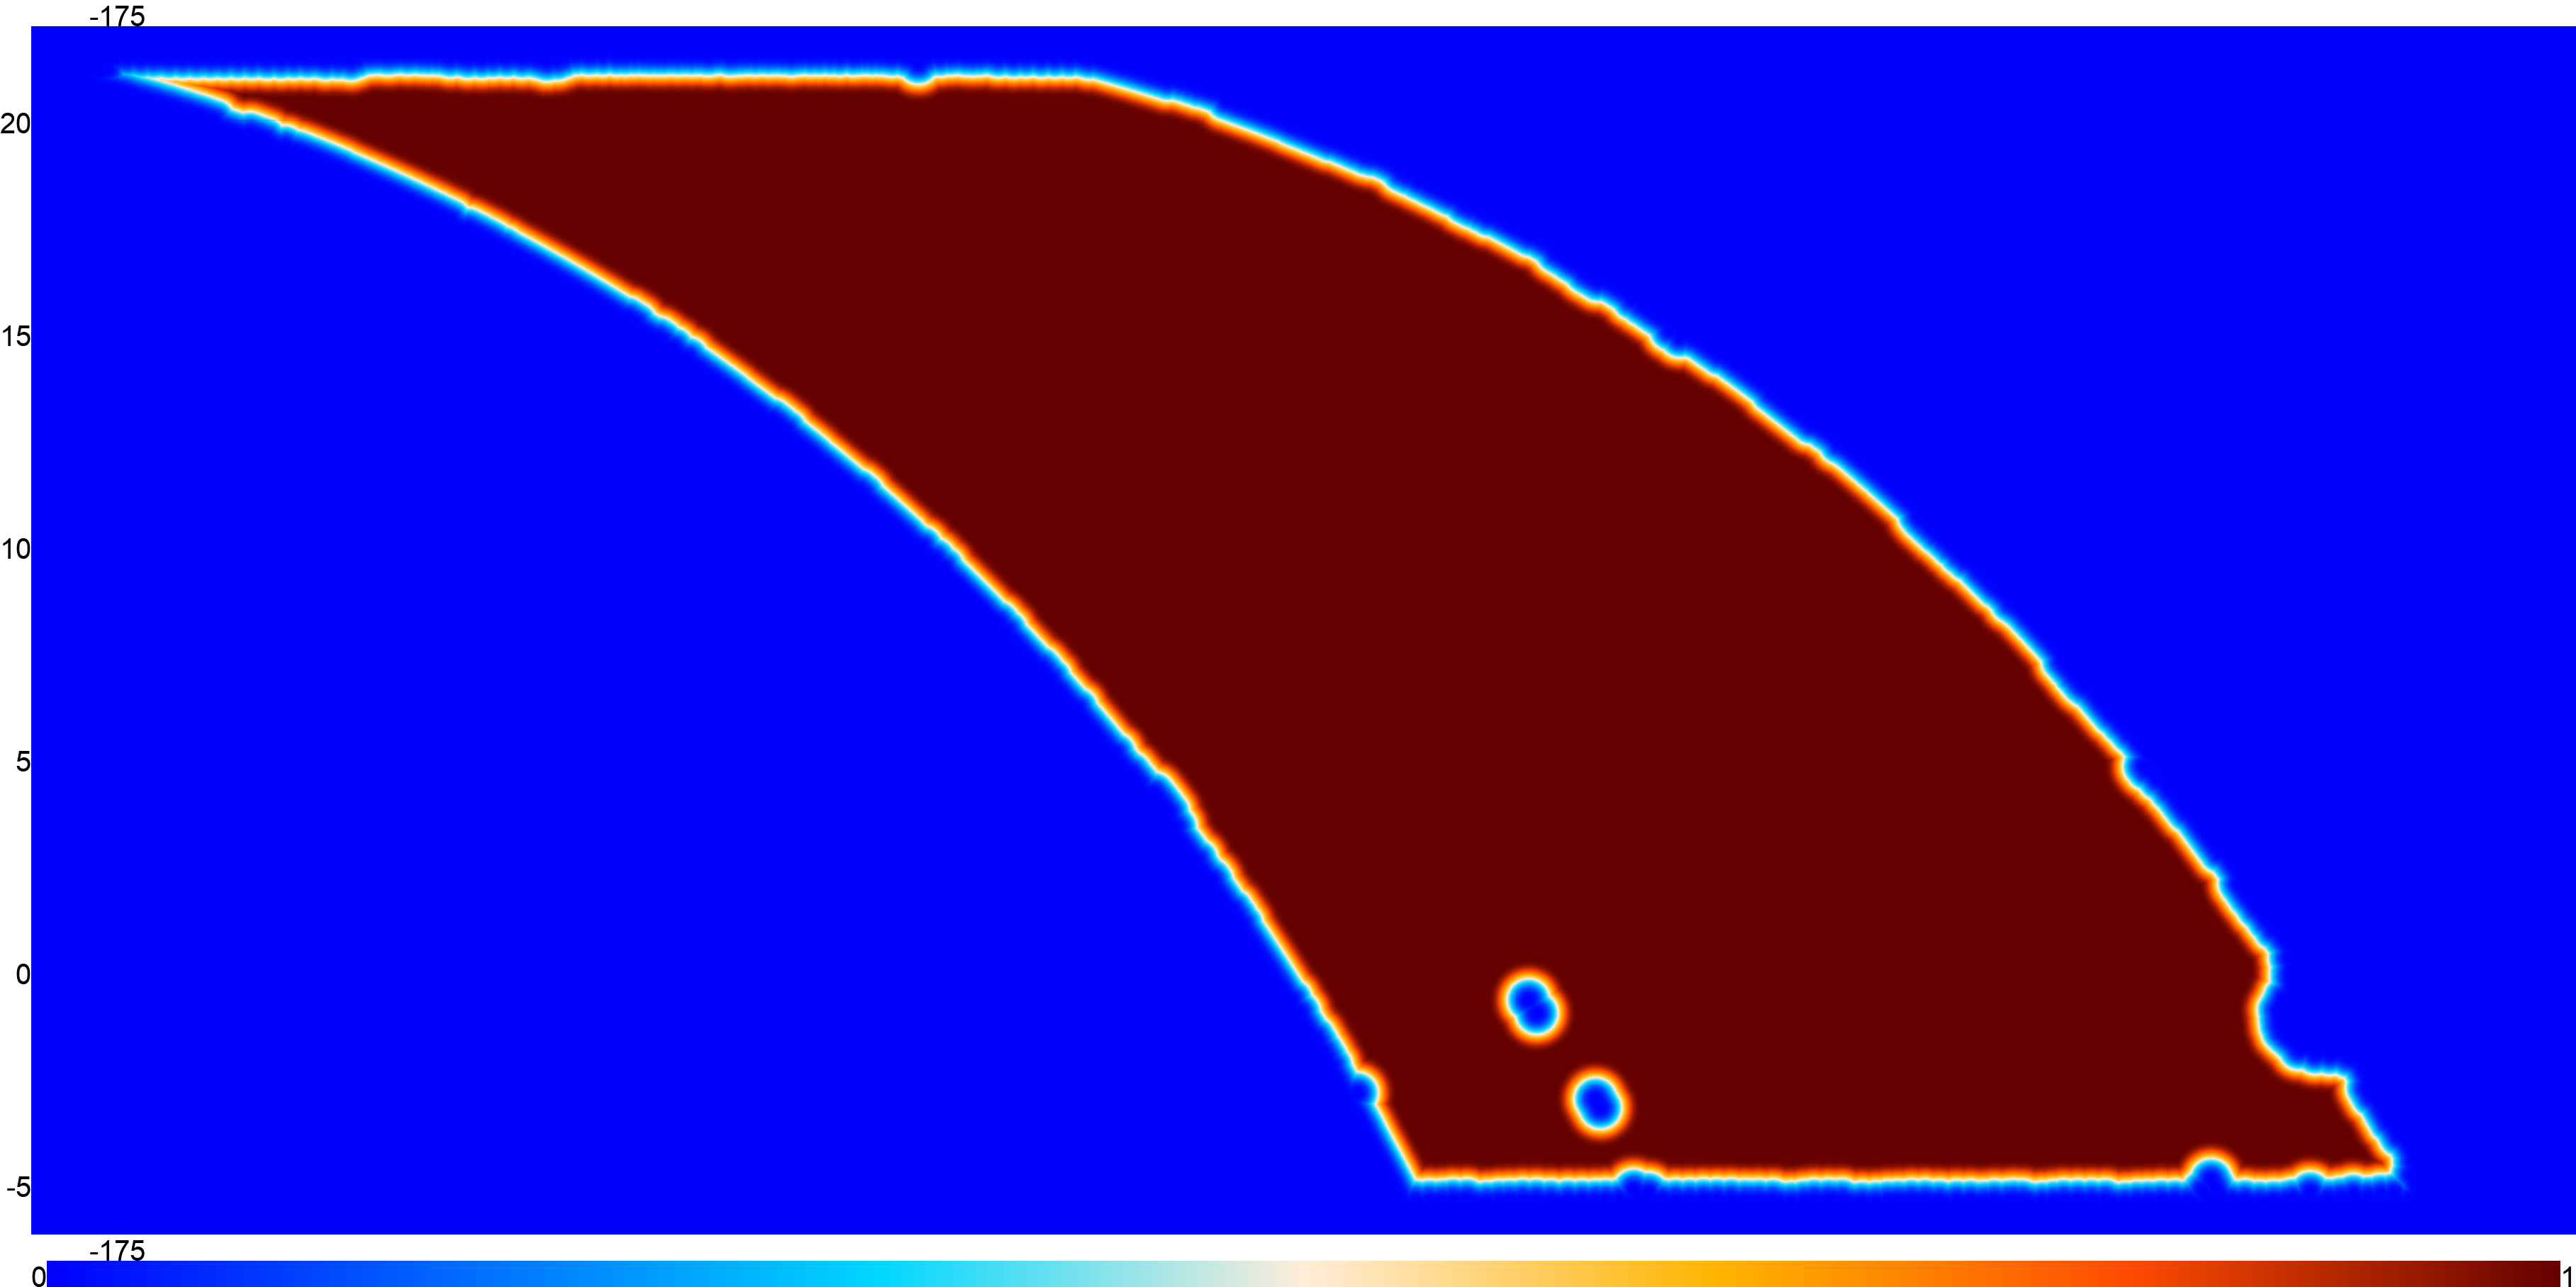

In [24]:
ivar_path = depth1_path[:-8] + "ivar.fits"
depth1_ivar = 0.5*enmap.read_map(ivar_path) # 0.5 for polarization noise
depth1_mask, depth1_indices = make_tapered_mask(depth1_ivar,filter_radius=1.0,plot=True)

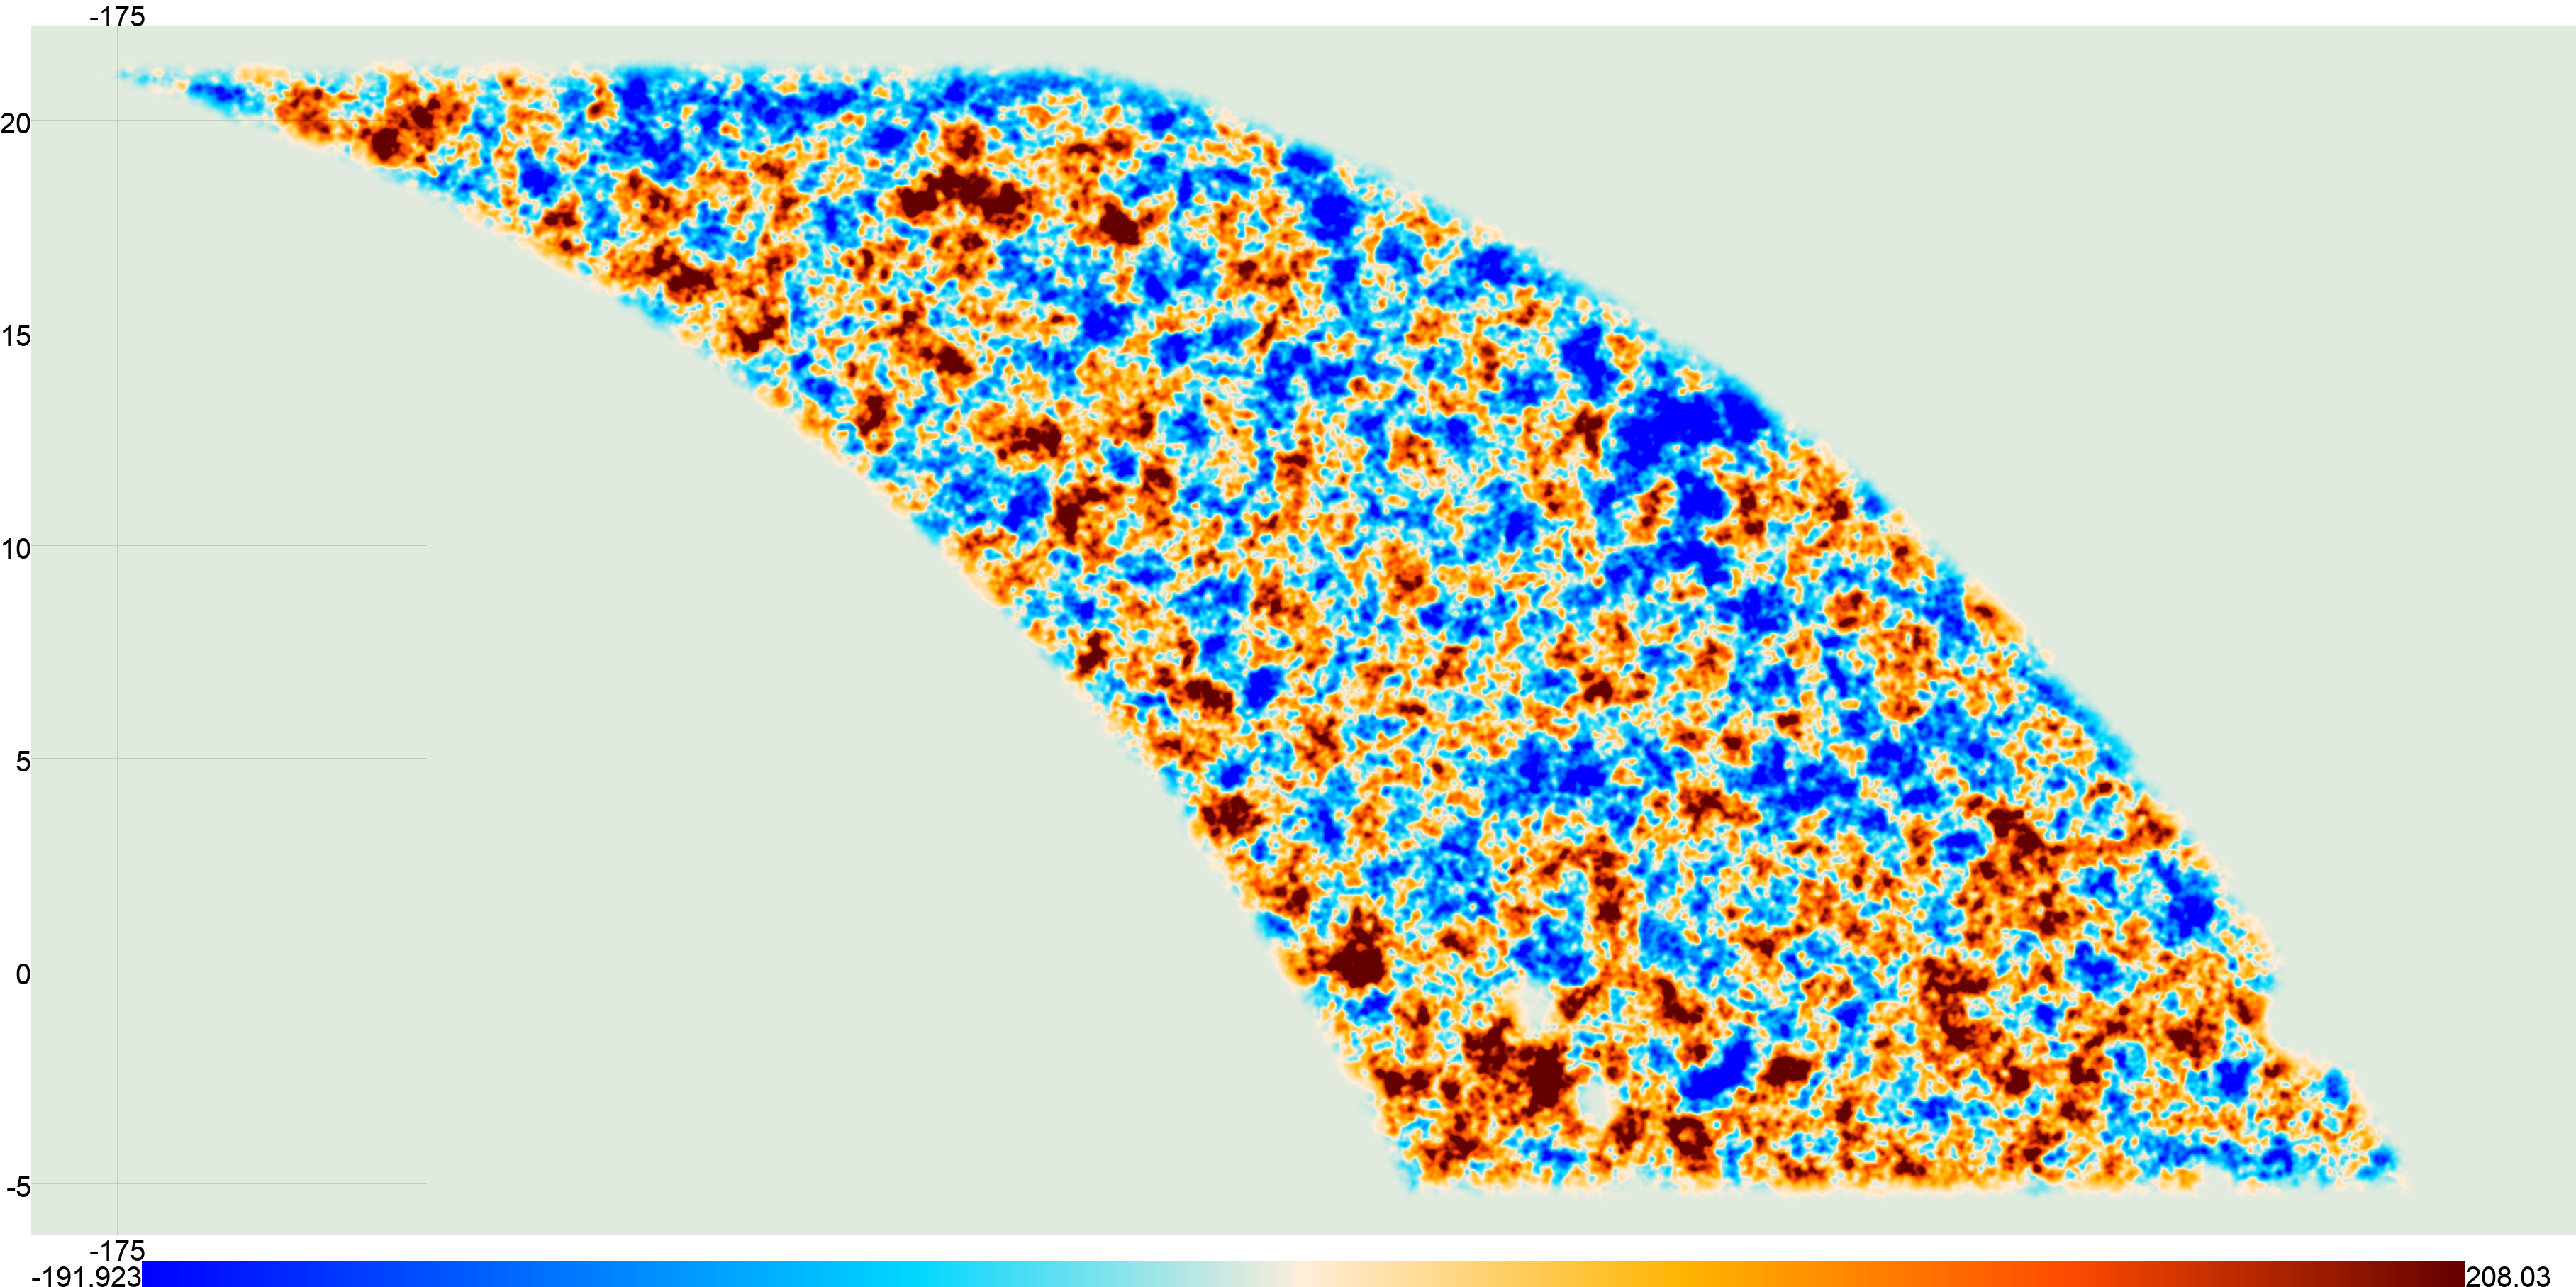

In [25]:
eshow(test_map*depth1_mask, **keys_eshow)

In [26]:
# Just using regular bins for now instead of the ACT bins
lmax = 5000
bin_size = 25
bins = np.arange(0, lmax, bin_size)
centers = (bins[1:] + bins[:-1])/2.
print(bins)

[   0   25   50   75  100  125  150  175  200  225  250  275  300  325
  350  375  400  425  450  475  500  525  550  575  600  625  650  675
  700  725  750  775  800  825  850  875  900  925  950  975 1000 1025
 1050 1075 1100 1125 1150 1175 1200 1225 1250 1275 1300 1325 1350 1375
 1400 1425 1450 1475 1500 1525 1550 1575 1600 1625 1650 1675 1700 1725
 1750 1775 1800 1825 1850 1875 1900 1925 1950 1975 2000 2025 2050 2075
 2100 2125 2150 2175 2200 2225 2250 2275 2300 2325 2350 2375 2400 2425
 2450 2475 2500 2525 2550 2575 2600 2625 2650 2675 2700 2725 2750 2775
 2800 2825 2850 2875 2900 2925 2950 2975 3000 3025 3050 3075 3100 3125
 3150 3175 3200 3225 3250 3275 3300 3325 3350 3375 3400 3425 3450 3475
 3500 3525 3550 3575 3600 3625 3650 3675 3700 3725 3750 3775 3800 3825
 3850 3875 3900 3925 3950 3975 4000 4025 4050 4075 4100 4125 4150 4175
 4200 4225 4250 4275 4300 4325 4350 4375 4400 4425 4450 4475 4500 4525
 4550 4575 4600 4625 4650 4675 4700 4725 4750 4775 4800 4825 4850 4875
 4900 

In [27]:
fourier_map = enmap.map2harm(test_map*depth1_mask,normalize='phys')
binned_TT, bincount = spectrum_from_maps(fourier_map, fourier_map, b_ell_bin_1=1.0, \
                                         b_ell_bin_2=1.0, w2=np.mean(depth1_mask*depth1_mask), bins=bins)

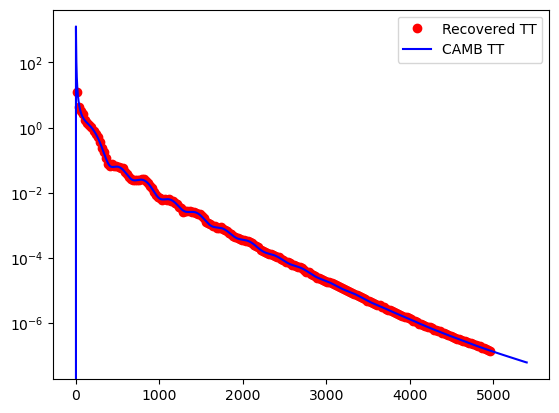

In [28]:
plt.semilogy(centers,binned_TT,'ro',label='Recovered TT')
plt.semilogy(ell,ClTT,'b',label='CAMB TT')
plt.legend()
plt.show()
plt.close()

Now that things seem to be working with this, I'll try running a bunch of simulations and see what we get.

In [50]:
N_sims = 100
lmin = 2
lmax = 5000
bin_size = 1

bins = np.arange(lmin, lmax, bin_size)
centers = (bins[1:] + bins[:-1])/2.

spectra = []
bincounts = []

for i in tqdm(range(N_sims)):
    alm = hp.sphtfunc.synalm(ClTT)
    input_map = curvedsky.alm2map(alm, depth1_T, spin=[0])
    fourier_map = enmap.map2harm(input_map*depth1_mask,normalize='phys')
    binned_TT, bincount = spectrum_from_maps(fourier_map, fourier_map, b_ell_bin_1=1.0, \
                                         b_ell_bin_2=1.0, w2=np.mean(depth1_mask*depth1_mask), bins=bins)
    spectra.append(binned_TT)
    bincounts.append(bincount)
    
spectra = np.array(spectra)
bincounts = np.array(bincounts)

  0%|                                                                                                                                     | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_11409/4031772201.py:61: RuntimeWarning: invalid value encountered in divide
  binned = np.bincount(digitized, spectrum.reshape(-1))[1:-1]/bincount
  1%|█▎                                                                                                                           | 1/100 [00:04<07:19,  4.43s/it]/tmp/ipykernel_11409/4031772201.py:61: RuntimeWarning: invalid value encountered in divide
  binned = np.bincount(digitized, spectrum.reshape(-1))[1:-1]/bincount
  2%|██▌                                                                                                                          | 2/100 [00:08<07:00,  4.29s/it]/tmp/ipykernel_11409/4031772201.py:61: RuntimeWarning: invalid value encountered in divide
  binned = np.bincount(digitized, spectrum.reshape(-1))[1:-1]/bincount
  3%|███▊                   

 50%|██████████████████████████████████████████████████████████████                                                              | 50/100 [03:38<03:39,  4.40s/it]/tmp/ipykernel_11409/4031772201.py:61: RuntimeWarning: invalid value encountered in divide
  binned = np.bincount(digitized, spectrum.reshape(-1))[1:-1]/bincount
 51%|███████████████████████████████████████████████████████████████▏                                                            | 51/100 [03:42<03:35,  4.40s/it]/tmp/ipykernel_11409/4031772201.py:61: RuntimeWarning: invalid value encountered in divide
  binned = np.bincount(digitized, spectrum.reshape(-1))[1:-1]/bincount
 52%|████████████████████████████████████████████████████████████████▍                                                           | 52/100 [03:47<03:31,  4.40s/it]/tmp/ipykernel_11409/4031772201.py:61: RuntimeWarning: invalid value encountered in divide
  binned = np.bincount(digitized, spectrum.reshape(-1))[1:-1]/bincount
 53%|███████████████████████

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:17<00:00,  4.38s/it]


In [75]:
np.array_equal(bincounts[0],bincounts[1])

True

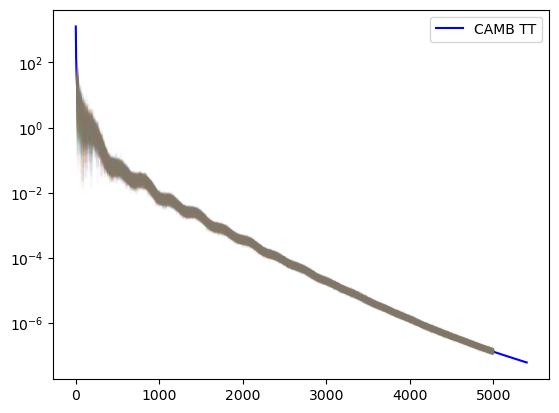

In [51]:
plt.semilogy(ell[2:],ClTT[2:],'b',label='CAMB TT')
for i in range(len(spectra)):
    plt.semilogy(centers,spectra[i],alpha=0.05)
plt.legend()
plt.show()
plt.close()

In [52]:
print(spectra.shape)
variance = np.var(spectra,axis=0)
print(variance.shape)
print(centers.shape)

(100, 4997)
(4997,)
(4997,)


In [53]:
# binning CAMB input to match my spectra
digitized = np.digitize(ell[2:], bins, right=True)
CAMB_ClTT_binned = np.bincount(digitized, ClTT[2:].reshape(-1))[1:-1]/np.bincount(digitized)[1:-1]
print(CAMB_ClTT_binned.shape)

(4997,)


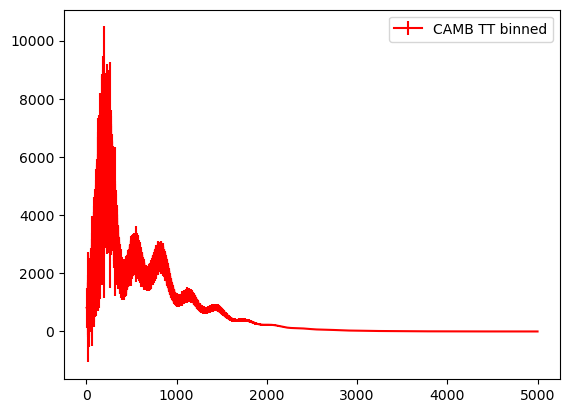

In [54]:
#plt.semilogy(centers,centers*(centers+1)*CAMB_ClTT_binned/(2*np.pi),'ro',label='CAMB TT binned')
#plt.semilogy(ell[2:],ell[2:]*(ell[2:]+1)*ClTT[2:]/(2*np.pi),'b',label='CAMB TT')
plt.errorbar(centers,centers*(centers+1)*CAMB_ClTT_binned/(2*np.pi),yerr=centers*(centers+1)*np.sqrt(variance)/(2*np.pi),fmt='r',label='CAMB TT binned')
plt.legend()
plt.show()
plt.close()

w2: 0.33581580180667353
w2w4: 0.34284425609329683


/tmp/ipykernel_11409/3712739868.py:7: RuntimeWarning: divide by zero encountered in divide
  theory_var = 2*CAMB_ClTT_binned**2/(bincount*w2)
/tmp/ipykernel_11409/3712739868.py:8: RuntimeWarning: divide by zero encountered in divide
  theory_var_w2w4 = 2*CAMB_ClTT_binned**2/(bincount*w2w4)


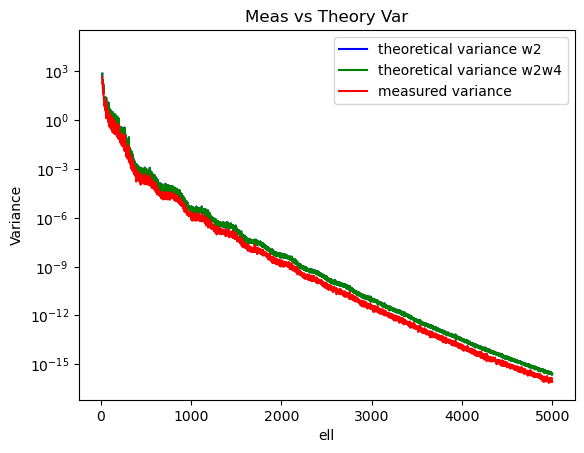

In [67]:
# the theoretical variance is 2*TT_theory^2/(bincount*window_factor)
# plotting that against the measured variance
w2 = np.mean(depth1_mask*depth1_mask)
w2w4 = np.mean(depth1_mask**2)**2 / np.mean(depth1_mask**4)
print("w2: " + str(w2))
print("w2w4: " + str(w2w4))
theory_var = 2*CAMB_ClTT_binned**2/(bincount*w2)
theory_var_w2w4 = 2*CAMB_ClTT_binned**2/(bincount*w2w4)

plt.semilogy(centers,theory_var,'b',label='theoretical variance w2')
plt.semilogy(centers,theory_var,'g',label='theoretical variance w2w4')
plt.semilogy(centers,variance,'r',label='measured variance')
plt.legend()
plt.title("Meas vs Theory Var")
plt.ylabel("Variance")
plt.xlabel("ell")
plt.show()
plt.close()

[  0   0   0 ... 432 376 446]


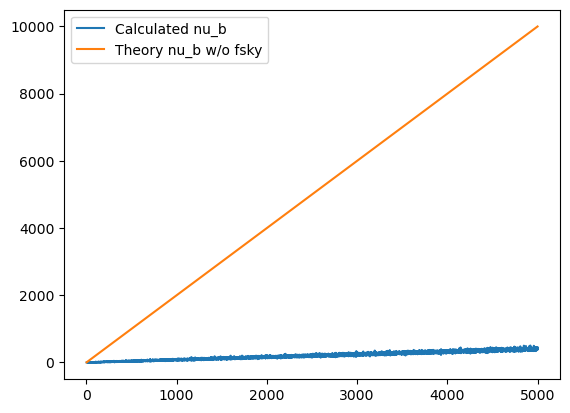

In [68]:
print(bincount)

theory_bincount = (2*centers + 1)*bin_size

plt.plot(centers,bincount,label="Calculated nu_b")
plt.plot(centers,theory_bincount,label="Theory nu_b w/o fsky")
plt.legend()
plt.show()
plt.close()

In [39]:
def get_hivon_fsky_enmap(mask):
    imap = mask/np.max(mask)
    w2w4 = (np.mean(imap**2.)**2./np.mean(imap**4.))
    skyarea = imap.area()/(4.*np.pi)*w2w4
    return skyarea

In [89]:
f_sky = get_hivon_fsky_enmap(depth1_mask) 
theory_bincount_w_fsky = (2*centers + 1)*bin_size*f_sky
print(f_sky)

0.013837504089267325


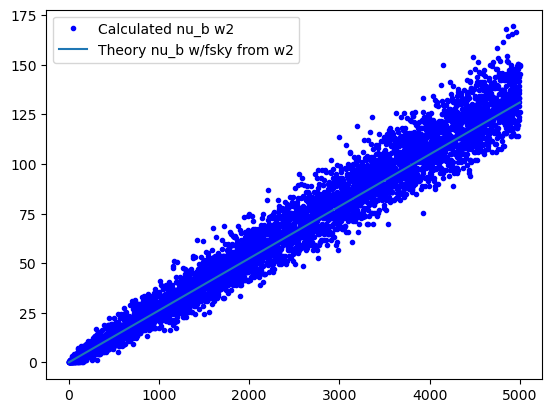

In [61]:
plt.plot(centers,bincount*w2,'b.',label="Calculated nu_b w2")
#plt.plot(centers,bincount*w2w4,label="Calculated nu_b w2w4")
#plt.plot(centers,theory_bincount_w_fsky,label="Theory nu_b w/fsky from w2w4")
plt.plot(centers,theory_bincount_w_fsky*w2/w2w4,label="Theory nu_b w/fsky from w2")
plt.legend()
plt.show()
plt.close()

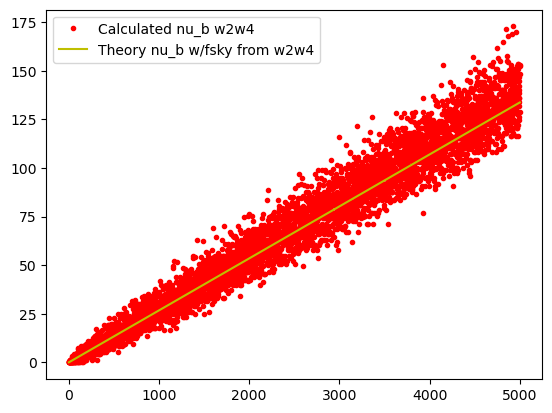

In [72]:
plt.plot(centers,bincount*w2w4,'r.',label="Calculated nu_b w2w4")
plt.plot(centers,theory_bincount_w_fsky,'y',label="Theory nu_b w/fsky from w2w4")
plt.legend()
plt.show()
plt.close()

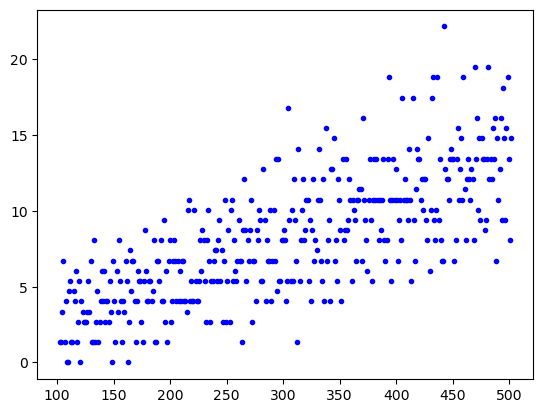

In [64]:
# Zooming in to see what the scatter is
plt.plot(centers[100:500],bincount[100:500]*w2,'b.',label="Calculated nu_b w2")
plt.show()
plt.close()

**-------------------------------------------------------------------------**

**-------------------------------------------------------------------------**

**-------------------------------------------------------------------------**


In [117]:
# Trying it again with more realistic bin size of 50
N_sims = 100
lmin = 50
lmax = 5000
bin_size = 50

bins = np.arange(lmin, lmax, bin_size)
centers = (bins[1:] + bins[:-1])/2.

spectra = []

for i in tqdm(range(N_sims)):
    alm = hp.sphtfunc.synalm(ClTT)
    input_map = curvedsky.alm2map(alm, depth1_T, spin=[0])
    fourier_map = enmap.map2harm(input_map*depth1_mask,normalize='phys')
    binned_TT, bincount = spectrum_from_maps(fourier_map, fourier_map, b_ell_bin_1=1.0, \
                                         b_ell_bin_2=1.0, w2=np.mean(depth1_mask*depth1_mask), bins=bins)
    spectra.append(binned_TT)
    
spectra = np.array(spectra)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:42<00:00,  4.63s/it]


In [118]:
centers

array([  75.,  125.,  175.,  225.,  275.,  325.,  375.,  425.,  475.,
        525.,  575.,  625.,  675.,  725.,  775.,  825.,  875.,  925.,
        975., 1025., 1075., 1125., 1175., 1225., 1275., 1325., 1375.,
       1425., 1475., 1525., 1575., 1625., 1675., 1725., 1775., 1825.,
       1875., 1925., 1975., 2025., 2075., 2125., 2175., 2225., 2275.,
       2325., 2375., 2425., 2475., 2525., 2575., 2625., 2675., 2725.,
       2775., 2825., 2875., 2925., 2975., 3025., 3075., 3125., 3175.,
       3225., 3275., 3325., 3375., 3425., 3475., 3525., 3575., 3625.,
       3675., 3725., 3775., 3825., 3875., 3925., 3975., 4025., 4075.,
       4125., 4175., 4225., 4275., 4325., 4375., 4425., 4475., 4525.,
       4575., 4625., 4675., 4725., 4775., 4825., 4875., 4925.])

In [119]:
# Calculating variance
print(spectra.shape)
variance = np.var(spectra,axis=0)
mean = np.mean(spectra, axis=0)
print(variance.shape)
print(centers.shape)
print(mean.shape)

# binning CAMB input to match my spectra
digitized = np.digitize(ell[2:], bins, right=True)
CAMB_ClTT_binned = np.bincount(digitized, ClTT[2:].reshape(-1))[1:-1]/np.bincount(digitized)[1:-1]
print(CAMB_ClTT_binned.shape)

(100, 98)
(98,)
(98,)
(98,)
(98,)


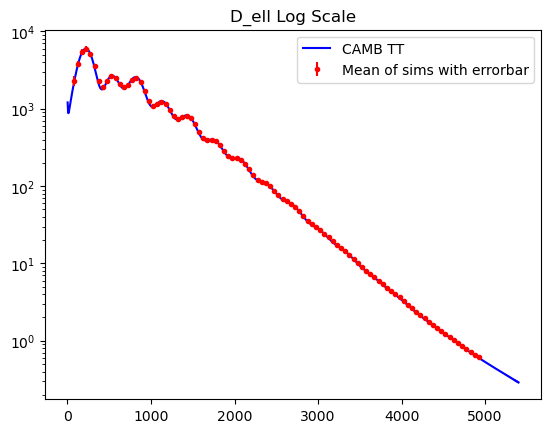

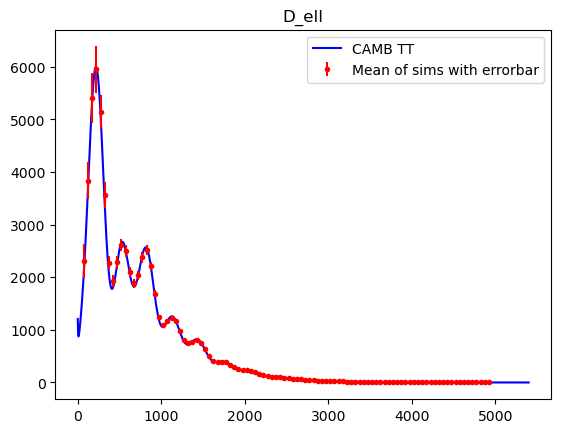

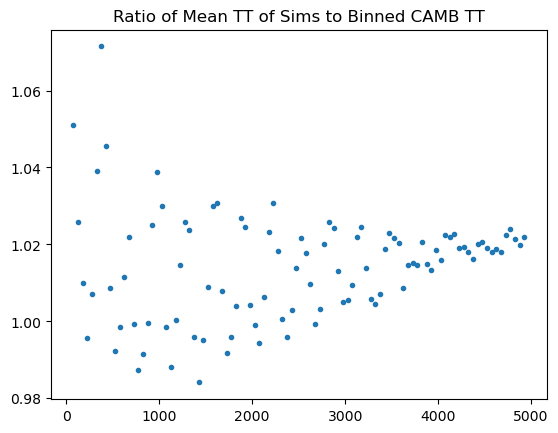

In [125]:
#plt.semilogy(ell[2:],ClTT[2:],'b',label='CAMB TT')
#for i in range(len(spectra)):
#    plt.semilogy(centers,spectra[i],alpha=0.05)
#plt.title("C_ell")
#plt.legend()
#plt.show()
#plt.close()

#plt.semilogy(centers,centers*(centers+1)*CAMB_ClTT_binned/(2*np.pi),'ro',label='CAMB TT binned')
plt.semilogy(ell[2:],ell[2:]*(ell[2:]+1)*ClTT[2:]/(2*np.pi),'b',label='CAMB TT')
plt.errorbar(centers,centers*(centers+1)*mean/(2*np.pi),yerr=centers*(centers+1)*np.sqrt(variance)/(2*np.pi),fmt='r.',label='Mean of sims with errorbar')
plt.title("D_ell Log Scale")
plt.legend()
plt.show()
plt.close()

plt.plot(ell[2:],ell[2:]*(ell[2:]+1)*ClTT[2:]/(2*np.pi),'b',label='CAMB TT')
plt.errorbar(centers,centers*(centers+1)*mean/(2*np.pi),yerr=centers*(centers+1)*np.sqrt(variance)/(2*np.pi),fmt='r.',label='Mean of sims with errorbar')
plt.title("D_ell")
plt.legend()
plt.show()
plt.close()

# Plotting the ratio of mean of sims to CAMB D_TT
plt.plot(centers,mean/CAMB_ClTT_binned,'.')
plt.title("Ratio of Mean TT of Sims to Binned CAMB TT")
plt.show()
plt.close()

w2: 0.33581580180667353
w2w4: 0.34284425609329683


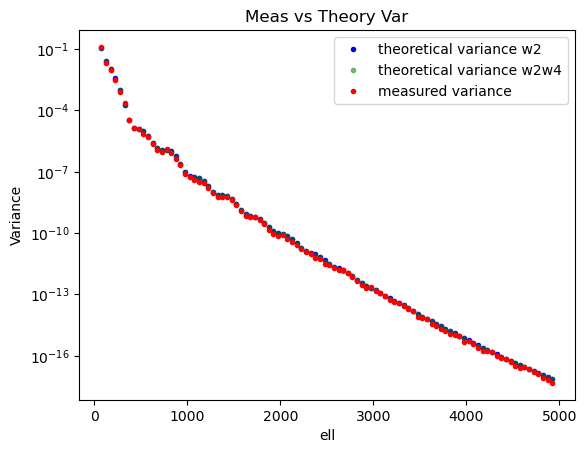

In [121]:
# the theoretical variance is 2*TT_theory^2/(bincount*window_factor)
# plotting that against the measured variance
w2 = np.mean(depth1_mask*depth1_mask)
w2w4 = np.mean(depth1_mask**2)**2 / np.mean(depth1_mask**4)
print("w2: " + str(w2))
print("w2w4: " + str(w2w4))
theory_var = 2*CAMB_ClTT_binned**2/(bincount*w2)
theory_var_w2w4 = 2*CAMB_ClTT_binned**2/(bincount*w2w4)

plt.semilogy(centers,theory_var,'b.',label='theoretical variance w2')
plt.semilogy(centers,theory_var_w2w4,'g.',label='theoretical variance w2w4',alpha=0.5)
plt.semilogy(centers,variance,'r.',label='measured variance')
plt.legend()
plt.title("Meas vs Theory Var")
plt.ylabel("Variance")
plt.xlabel("ell")
plt.show()
plt.close()

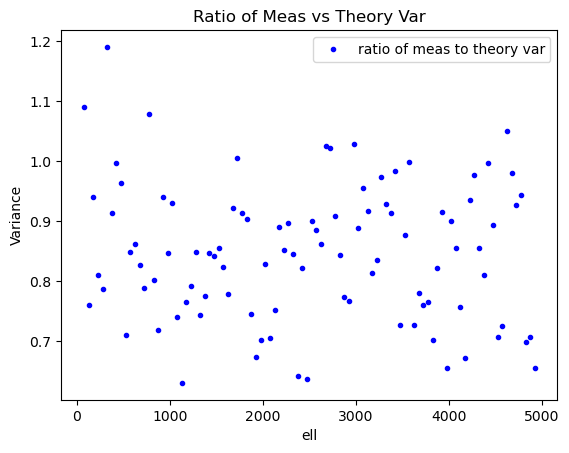

In [122]:
plt.plot(centers,variance/theory_var,'b.',label='ratio of meas to theory var')
plt.legend()
plt.title("Ratio of Meas vs Theory Var")
plt.ylabel("Variance")
plt.xlabel("ell")
plt.show()
plt.close()

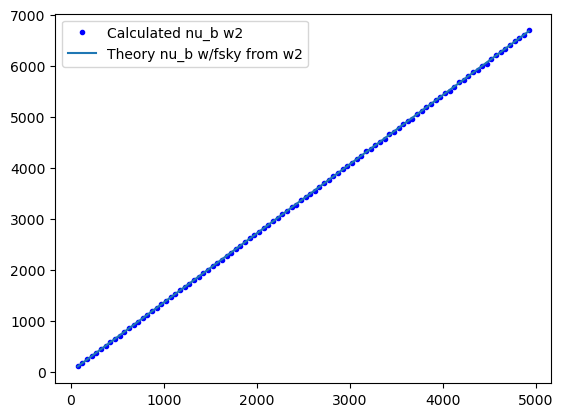

In [123]:
# Testing to see if the number of Fourier pixels matches (2l+1)*dl*fsky_eff
# Using the output of the Hivon sky area function above for fsky_eff
theory_bincount_w_fsky = (2*centers + 1)*bin_size*f_sky

plt.plot(centers,bincount*w2,'b.',label="Calculated nu_b w2")
# The Hivon sky area function uses w2w4 to calculate the sky fraction, so I divide by it
# before multiplying by w2 to check if there is a difference between using w2 or w2w4
# for the fsky value
plt.plot(centers,theory_bincount_w_fsky*w2/w2w4,label="Theory nu_b w/fsky from w2")
plt.legend()
plt.show()
plt.close()

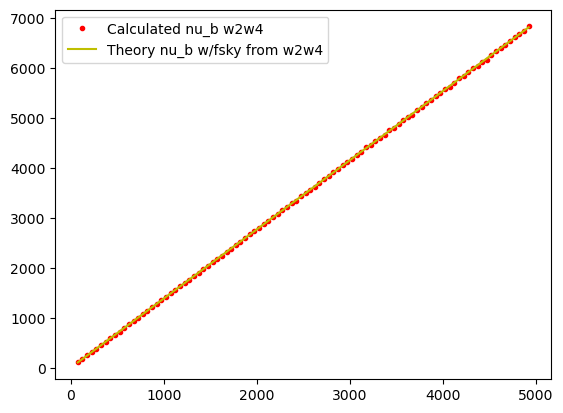

In [124]:
plt.plot(centers,bincount*w2w4,'r.',label="Calculated nu_b w2w4")
plt.plot(centers,theory_bincount_w_fsky,'y',label="Theory nu_b w/fsky from w2w4")
plt.legend()
plt.show()
plt.close()